In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from nctpy.utils import matrix_normalization
from snaplab_tools.utils import get_schaefer_system_mask, get_null_p, get_fdr_p

from brainsmash.mapgen.base import Base

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
outdir = '/home/lindenmp/research_projects/nct_xr/results'
fmri_concat = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat.npy'))
fmri_concat_subjidx = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat_subjidx.npy'))

In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'schaefer400-7_centroids.csv'), index_col=0)
print(parc_centroids.head())

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [4]:
file_prefix = 'hcp-Am_optimal-'

n_states = 7
c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()
log_args.keys()

hcp-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2


dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay', 'control_signals_corr_system', 'control_energy_system', 'numerical_error_system', 'xfcorr_system', 'control_signals_corr_system_variable_decay', 'control_energy_system_variable_decay', 'numerical_error_system_variable_decay', 'xfcorr_system_variable_decay'])

In [5]:
# load fMRI data
fmri_ts = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat.npy'))
fmri_ts_subjidx = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat_subjidx.npy'))

# load rsfMRI clusters
fmri_clusters_file = 'hcp_fmri_clusters_k-{0}.npy'.format(n_states)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_nodes = centroids.shape[1]
n_transitions = n_states * n_states

n_labels = labels.shape[0]
print('n_states, {0}; n_labels, {1}; n_nodes, {2}'.format(n_states, n_labels, n_nodes))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_labels, 873600; n_nodes, 400


# Optimized weights

In [6]:
adjacency_weights = np.zeros((n_states, n_states, n_nodes))
# adjacency_weights_2d = np.zeros((1, n_nodes))
for initial_idx in np.arange(n_states):
    for target_idx in np.arange(n_states):
        try:
            idx = np.where(np.isnan(log_args['loss'][initial_idx, target_idx]))[0][0] - 1
        except:
            idx = log_args['loss'].shape[-1] - 1
        optimized_weights = -1 - log_args['optimized_weights'][initial_idx, target_idx, idx]
        if np.any(optimized_weights > 0):
            print('warning, positive weights found')
        # optimized_weights = np.abs(optimized_weights)
        adjacency_weights[initial_idx, target_idx] = optimized_weights
        # if target_idx != initial_idx:
            # adjacency_weights_2d = np.append(adjacency_weights_2d, optimized_weights[np.newaxis, :], axis=0)
# adjacency_weights_2d = adjacency_weights_2d[1:, :]
adjacency_weights_2d = adjacency_weights.reshape(n_transitions, n_nodes)
adjacency_weights_mean = np.nanmean(adjacency_weights_2d, axis=0)

reference_states = np.zeros((n_states, n_states, n_nodes))
# reference_states_2d = np.zeros((1, n_nodes))

for initial_idx in np.arange(n_states):
    initial_state = centroids[initial_idx, :]
    for target_idx in np.arange(n_states):
        target_state = centroids[target_idx, :]
        
        if reference_state == 'xf':
            reference_states[initial_idx, target_idx] = target_state
        elif reference_state == 'midpoint':
            reference_states[initial_idx, target_idx] = initial_state + ((target_state - initial_state) * 0.5)
            
        # if target_idx != initial_idx:
            # reference_states_2d = np.append(reference_states_2d, reference_states[initial_idx, target_idx][np.newaxis, :], axis=0)

# reference_states_2d = reference_states_2d[1:, :]
reference_states_2d = reference_states.reshape(n_transitions, n_nodes)

# n_transitions = adjacency_weights_2d.shape[0]

print(adjacency_weights.shape, adjacency_weights_2d.shape, adjacency_weights_mean.shape, reference_states.shape, reference_states_2d.shape)

(7, 7, 400) (49, 400) (400,) (7, 7, 400) (49, 400)


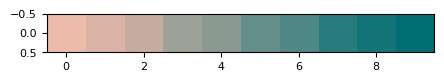

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

my_colors = get_my_colors()

colors = [my_colors['conch_shell'],
          my_colors['north_sea_green']]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=13)
mat = np.indices((1,10))[1]
f, ax = plt.subplots(1, 1, figsize=(5, 10))
ax.imshow(mat, cmap=cm)
f.savefig(os.path.join(outdir, 'optimized_weights_cmap.png'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()

-2.1401822006865823


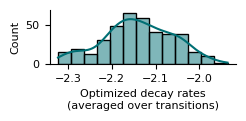

In [8]:
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.25))
sns.histplot(adjacency_weights_mean, ax=ax, kde=True, color=my_colors['north_sea_green'])
x_mean = np.nanmean(adjacency_weights_mean)
print(x_mean)
# ax.axvline(x=x_mean, c=my_colors['raspberry_blush'], linestyle='--')
# ax.invert_xaxis()
# ax.set_xlabel('--> stronger self-inhibition\nOptimized decay rates\n(averaged over transitions)')
ax.set_xlabel('Optimized decay rates\n(averaged over transitions)')
sns.despine(ax=ax)
f.tight_layout()
f.savefig(os.path.join(outdir, 'optimized_weights_mean.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()

-1.9356646283816326 -2.3228315319215787


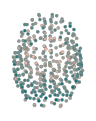

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


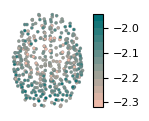

In [9]:
print(adjacency_weights_mean.max(), adjacency_weights_mean.min())
f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_mean,
                       vmin=np.round(adjacency_weights_mean.min(), 2), vmax=np.round(adjacency_weights_mean.max(), 2), add_colorbar=False, cmap=cm)
f.savefig(os.path.join(outdir, 'optimized_weights_mean_brain_map.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_mean,
                       vmin=np.round(adjacency_weights_mean.min(), 2), vmax=np.round(adjacency_weights_mean.max(), 2), add_colorbar=True, cmap=cm)
f.savefig(os.path.join(outdir, 'optimized_weights_mean_brain_map_cb.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

## PCA of Optimized weights

In [10]:
adjacency_weights_2d.shape

(49, 400)

In [11]:
n_components = 5
pca = PCA(n_components=n_components)

pca_results = pca.fit_transform(sp.stats.zscore(adjacency_weights_2d, axis=0))
print(pca_results.shape)
print(np.round(pca.explained_variance_ratio_*100))
print(np.round(pca.explained_variance_ratio_.sum()*100))
adjacency_weights_pca = pca.components_
adjacency_weights_pca = -1 * adjacency_weights_pca

print(adjacency_weights_pca.shape, adjacency_weights_pca.max(), adjacency_weights_pca.min())

(49, 5)
[30. 19. 16. 12.  8.]
86.0
(5, 400) 0.1163875576863293 -0.14550051370706027


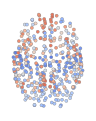

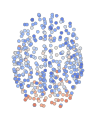

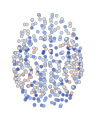

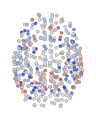

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


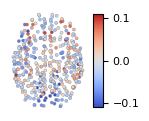

In [12]:
observed_corrs = []
p_vals = []
for i in np.arange(n_components):
    if i == n_components - 1:
        add_colorbar = True
    else:
        add_colorbar = False
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_pca[i, :], vmin=-.11, vmax=.11, cmap='coolwarm', add_colorbar=add_colorbar) 
    f.savefig(os.path.join(outdir, 'adjacency_weights_pc_{0}_brain_map.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)
    
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i, :], adjacency_weights_mean)[0]
    p_val = sp.stats.spearmanr(adjacency_weights_pca[i, :], adjacency_weights_mean)[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)

In [13]:
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in np.arange(n_components):
    print('corr(PC {0}, mean weights). r = {1}; pFDR = {2}'.format(i+1, np.round(observed_corrs[i], 2), np.round(p_vals_fdr[i], 3)))

corr(PC 1, mean weights). r = 0.16; pFDR = 0.007
corr(PC 2, mean weights). r = -0.01; pFDR = 0.771
corr(PC 3, mean weights). r = 0.04; pFDR = 0.593
corr(PC 4, mean weights). r = 0.14; pFDR = 0.015
corr(PC 5, mean weights). r = -0.08; pFDR = 0.208


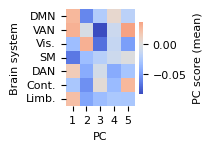

In [14]:
yeo_systems = ['Default', 'SalVentAttn', 'Vis', 'SomMot', 'DorsAttn', 'Cont', 'Limbic'] # k = 7
yeo_systems_labels = ['DMN', 'VAN', 'Vis.', 'SM', 'DAN', 'Cont.', 'Limb.'] # k = 7
n_systems = len(yeo_systems)
mean_activity = np.zeros((n_systems, n_components))
for system_idx in np.arange(n_systems):
    system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
    for pc_idx in np.arange(n_components):
        mean_activity[system_idx, pc_idx] = adjacency_weights_pca[pc_idx, system_mask].mean()
        
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))

sns.heatmap(mean_activity, square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.75, 'label': 'PC score (mean)'}) # vmin=-5, vmax=5, 
ax.set_xlabel('PC')
ax.set_ylabel('Brain system')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
ax.set_yticklabels(yeo_systems_labels, rotation=0)
f.savefig(os.path.join(outdir, "weights_pca_system_mapping.svg".format(n_states, pc_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

# Load brain maps

In [15]:
# myelin matrix
sa_axis = np.load(os.path.join(indir, 'schaefer400-7_sa-axis.npy'))

feature = 'features_schaefer_streamcount_areanorm_log'
adjacency = np.load(os.path.join(indir, 'hcp_schaefer400-7_Am-{0}.npy'.format(feature)))
strength = adjacency.sum(axis=0)

myelin = np.load(os.path.join(indir, 'hcp_schaefer400-7_myelin.npy'))
myelin = myelin.mean(axis=1)

timescales = np.load(os.path.join(indir, 'hcp_schaefer400-7_rsacf.npy'))
timescales = timescales[:, 0, :]
timescales = timescales.mean(axis=1)

print(sa_axis.shape, strength.shape, myelin.shape, timescales.shape)

(400,) (400,) (400,) (400,)


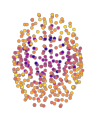

In [16]:
f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=timescales, cmap = 'plasma')
f.savefig(os.path.join(outdir, 'empirical_timescales_brain_map.png'), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [18]:
observed_corrs = []
p_vals = []
for i in [0, 3]:
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i, :], timescales)[0]
    p_val = sp.stats.spearmanr(adjacency_weights_pca[i, :], timescales)[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)
    
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in [0, 1]:
    print('corr(PC, timescale). r = {:.2f}; pFDR = {:.2f}'.format(observed_corrs[i], p_vals_fdr[i]))

corr(PC, timescale). r = 0.44; pFDR = 0.00
corr(PC, timescale). r = 0.05; pFDR = 0.29


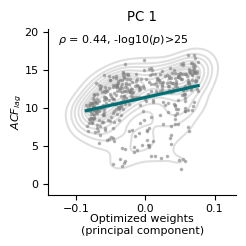

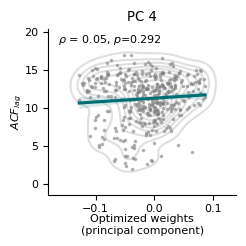

In [19]:
# adjacency_weights_plot = adjacency_weights_mean
# xlabel = 'fast   -->   slow\nOptimized weights (mean)'
# f, ax = plt.subplots(1, 1, figsize=(2, 2))
# reg_plot(adjacency_weights_plot, adjacency_weights_mean, xlabel=xlabel, ylabel='mean', ax=ax, annotate='both')

for i in [0, 3]:
    f, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    # xlabel = '(fast   -->   slow)\nOptimized weights\n(PC coefs.)'
    xlabel = 'Optimized weights\n(principal component)'
    reg_plot(adjacency_weights_pca[i, :], timescales, xlabel=xlabel, ylabel='$ACF_{lag}$', ax=ax, annotate='spearman')
    ax.set_title('PC {0}'.format(i + 1))
    f.tight_layout()
    f.savefig(os.path.join(outdir, 'optimized_weights_PC_{0}_timescales_correlation.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)
    
adjacency_weights_plot = adjacency_weights_pca[0, :]
# xlabel = '(fast   -->   slow)\nOptimized weights (PC 1 coefs.)'

# Null models

In [20]:
run_null = True

In [21]:
if run_null:
    n_perms = 5000
    nulls = ['hcp_adj_perm', 'hcp_state_perm']
    n_nulls = len(nulls)

    control_energy_variable_decay_null = np.zeros((n_nulls, n_states, n_states, n_perms))
    control_energy_static_decay_null = np.zeros((n_nulls, n_states, n_states, n_perms))
    adjacency_weights_null = np.zeros((n_nulls, n_states, n_states, n_nodes, n_perms))
    # adjacency_weights_null = np.zeros((n_transitions, n_nodes, n_perms))

    for n, which_null in enumerate(nulls):
        print(which_null)

        for i in tqdm(np.arange(n_perms)):
            if which_null == 'hcp_adj_perm':
                nulldir = os.path.join(outdir, 'hcp_adj_perm')
                file_prefix_null = 'wsp-adj-{0}_optimal-'.format(i)
                # file_prefix_null = 'wwp-adj-{0}_optimal-'.format(i)
            elif which_null == 'hcp_state_perm':
                nulldir = os.path.join(outdir, 'hcp_state_perm')
                file_prefix_null = 'hcp-Am_surr-target-{0}_optimal-'.format(i)


            file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix_null, 
                                                                                                                                                                    n_states, 
                                                                                                                                                                    c, time_horizon, rho,
                                                                                                                                                                    reference_state, init_weights,
                                                                                                                                                                    n_steps, lr, eig_weight, reg_weight, reg_type)
            if i == 0:
                print(file_str)

            try:
                log_args_null = np.load(os.path.join(nulldir, file_str + '.npy'), allow_pickle=True).item()
                control_energy_variable_decay_null[n, :, :, i] = log_args_null['control_energy_variable_decay']
                control_energy_static_decay_null[n, :, :, i] = log_args_null['control_energy_static_decay']

                for initial_idx in np.arange(n_states):
                    for target_idx in np.arange(n_states):
                        optimized_weights = -1 - log_args_null['optimized_weights'][initial_idx, target_idx, :]
                        adjacency_weights_null[n, initial_idx, target_idx, :, i] = optimized_weights

            except FileNotFoundError:
                print('file missing {0}'.format(file_str))
                control_energy_variable_decay_null[n, :, :, i] = np.nan
                control_energy_static_decay_null[n, :, :, i] = np.nan    
                adjacency_weights_null[n, :, :, i] = np.nan

        print(np.any(np.isinf(control_energy_variable_decay_null)), np.any(np.isnan(control_energy_variable_decay_null)))

hcp_adj_perm


 14%|█▎        | 687/5000 [00:00<00:01, 3575.20it/s]

wsp-adj-0_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2


100%|██████████| 5000/5000 [00:01<00:00, 4250.71it/s]


False False
hcp_state_perm


  7%|▋         | 334/5000 [00:00<00:01, 3335.24it/s]

hcp-Am_surr-target-0_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2


100%|██████████| 5000/5000 [00:01<00:00, 4313.13it/s]

False False


### PCA

In [22]:
if run_null:
    pca = PCA(n_components=1)
    adjacency_weights_null_pca = np.zeros((n_nulls, n_perms, n_nodes))
    null_corr_pca = np.zeros((n_nulls, n_perms))
    for n, which_null in enumerate(nulls):
        print(which_null)
        for i in tqdm(np.arange(n_perms)):
            adjacency_weights_tmp = adjacency_weights_null[n, :, :, :, i].reshape(n_transitions, n_nodes)
            pca_results = pca.fit_transform(sp.stats.zscore(adjacency_weights_tmp, axis=0))
            adjacency_weights_null_pca[n, i, :] = -1 * pca.components_[0]
            null_corr_pca[n, i] = sp.stats.spearmanr(adjacency_weights_null_pca[n, i, :], timescales)[0]

hcp_adj_perm


100%|██████████| 5000/5000 [00:14<00:00, 349.26it/s]


hcp_state_perm


100%|██████████| 5000/5000 [00:14<00:00, 352.44it/s]


0.4410170779881726
hcp_adj_perm
hcp_state_perm


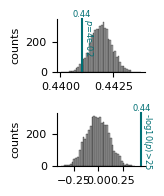

In [23]:
if run_null:
    f, ax = plt.subplots(n_nulls, 1, figsize=(1.75, 2))

    observed_corr = sp.stats.spearmanr(adjacency_weights_plot, timescales)[0]
    print(observed_corr)
    for n, which_null in enumerate(nulls):
        print(which_null)
        p_val = get_null_p(observed_corr, null_corr_pca[n], version='smallest')
        # print(p_val)
        null_plot(observed_corr, null_corr_pca[n], '', ax=ax[n], p_val=p_val, add_text=True)
        
    f.tight_layout()
    f.savefig(os.path.join(outdir, 'optimized_weights_PC_0_timescales_correlation_twin_nulls.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
    plt.show()

### Per-transition

In [24]:
if run_null:
    raw_effects = np.zeros((n_states, n_states))
    null_means = np.zeros((n_states, n_states, n_nulls))
    zscored_effects = np.zeros((n_states, n_states, n_nulls))
    p_vals = np.zeros((n_states, n_states, n_nulls))

    for initial_idx in tqdm(np.arange(n_states)):
        for target_idx in np.arange(n_states):
            observed_corr = sp.stats.spearmanr(adjacency_weights[initial_idx, target_idx], timescales)[0]

            raw_effects[initial_idx, target_idx] = observed_corr
            for n, which_null in enumerate(nulls):

                null_corr = np.zeros(n_perms)
                for i in np.arange(n_perms):
                    adj_weight = adjacency_weights_null[n, initial_idx, target_idx, :, i]
                    nan_mask = np.isnan(adj_weight)
                    null_corr[i] = sp.stats.spearmanr(adj_weight[~nan_mask], timescales[~nan_mask])[0]
                
                p_vals[initial_idx, target_idx, n] = get_null_p(observed_corr, null_corr, version='smallest')
                
                null_mean = np.mean(null_corr)
                null_std = np.std(null_corr)
                null_means[initial_idx, target_idx, n] = null_mean
                zscored_effects[initial_idx, target_idx, n] = (observed_corr - null_mean) / null_std

100%|██████████| 7/7 [04:10<00:00, 35.76s/it]


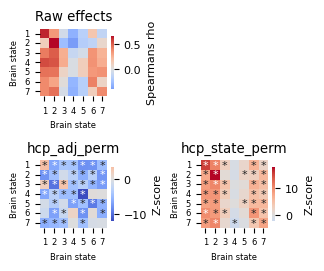

In [25]:
if run_null:
    f, ax = plt.subplots(2, n_nulls, figsize=(3.25, 2.75))
    ax[0,1].axis('off')

    # raw correlations
    sns.heatmap(raw_effects, ax=ax[0, 0], square=True, cbar_kws={'shrink': 0.75, 'label': 'Spearmans rho'}, cmap='coolwarm', center=0)
    ax[0, 0].set_title('Raw effects')

    # z-scored correlations
    for n, which_null in enumerate(nulls):
        sig_mask = get_fdr_p(p_vals=p_vals[:, :, n]) < 0.05
        # sig_mask = p_vals[:, :, n] < 0.05
        
        sig_mask_str = []
        for initial_idx in np.arange(n_states):
            sig_mask_row = []
            for target_idx in np.arange(n_states):
                if sig_mask[initial_idx, target_idx]:
                    sig_mask_row.append('*')
                else:
                    sig_mask_row.append('')
            sig_mask_str.append(sig_mask_row)
        
        sns.heatmap(zscored_effects[:, :, n], ax=ax[1, n], square=True, cbar_kws={'shrink': 0.75, 'label': 'Z-score'}, cmap='coolwarm', center=0, annot=np.asarray(sig_mask_str), fmt="")
        ax[1, n].set_title(which_null)

    for this_ax in ax.reshape(-1):
        this_ax.set_xlabel('Brain state', fontsize=6)
        this_ax.set_ylabel('Brain state', fontsize=6)
        this_ax.set_xticks(np.arange(n_states) + 0.5)
        this_ax.set_yticks(np.arange(n_states) + 0.5)
        this_ax.set_xticklabels(np.arange(n_states) + 1, rotation=0, fontsize=6)
        this_ax.set_yticklabels(np.arange(n_states) + 1, rotation=0, fontsize=6)

    f.tight_layout()
    f.savefig(os.path.join(outdir, 'state_transitions_timescales_correlation_twin_nulls.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
    plt.show()

# Gene expression analysis

### Load Allen Human Brain Atlas (AHBA) gene expression

In [26]:
from sklearn.impute import SimpleImputer

gene_expression = pd.read_csv('/media/lindenmp/storage_hdd_1/research_data/abagen/expression_schaefer400-7.csv', index_col=0)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
gene_expression = pd.DataFrame(data=imputer.fit_transform(gene_expression.values), columns=gene_expression.columns, index=gene_expression.index)

n_gene_maps = gene_expression.shape[1]
gene_expression.head()

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
label,,,,,,,,,,,,,,,,,,,,,
1,0.607480,0.665241,0.336723,0.512871,0.535616,0.349362,0.385011,0.604183,0.714513,0.612679,...,0.434829,0.686842,0.642691,0.779771,0.401910,0.591604,0.713567,0.314619,0.606908,0.411451
2,0.693737,0.537774,0.475546,0.463217,0.451536,0.431581,0.326428,0.675244,0.470909,0.481477,...,0.397754,0.693257,0.701007,0.579938,0.509886,0.500819,0.537473,0.302078,0.398450,0.606953
3,0.446310,0.490555,0.446556,0.454476,0.478724,0.285521,0.542609,0.566711,0.512363,0.633447,...,0.452174,0.529415,0.456184,0.576420,0.470598,0.578949,0.595638,0.538140,0.671158,0.630816
4,0.421246,0.391275,0.424500,0.610471,0.561524,0.509270,0.501330,0.610072,0.631187,0.461455,...,0.540839,0.429449,0.511955,0.415775,0.628025,0.464138,0.522724,0.610207,0.644276,0.473367
5,0.435436,0.188208,0.503914,0.537667,0.720855,0.575021,0.642950,0.369688,0.478085,0.330655,...,0.415171,0.612999,0.353114,0.436883,0.662798,0.698356,0.429079,0.834149,0.632280,0.315696


### Load Xihan's cell-type maps

In [27]:
# the 7 networks
schaefer400_7Networks = pd.read_csv(os.path.join(indir, 'cell_maps_Zhang2024', 'schaefer_400_7Net_labels_manually_added.csv'), header=None, index_col=0)

# Cell Types
Jorstad_schaefer400 = pd.read_csv(os.path.join(indir, 'cell_maps_Zhang2024', 'schaeffer_Jorstad_FullCombinedFullCombined_400_7Net_expr_mat_new_NormZscore0.3.csv'), header=0, index_col=-1)
Jorstad_schaefer400 = Jorstad_schaefer400.transpose()
# Jorstad_schaefer400.replace(0, 0.0001, inplace=True)
Jorstad_schaefer400.head()


cell,Lamp5,Pax6,Vip,Sncg,Lamp5 Lhx6,L5 ET,L5/6 NP,L6 CT,L6b,Astro,...,OPC,L2/3 IT,L6 IT Car3,L4 IT,L6 IT,L5 IT,Chandelier,Pvalb,Sst,Sst Chodl
7Networks_LH_Vis_1,0.017880,0.005211,0.024241,0.036149,0.046252,0.000679,0.044468,0.021496,0.040369,0.029252,...,0.020510,0.212280,0.017791,0.041477,0.104096,0.214250,0.015076,0.006961,0.051609,0.007797
7Networks_LH_Vis_2,0.015720,0.013763,0.055608,0.063072,0.036132,0.000000,0.052736,0.052417,0.037233,0.047726,...,0.031468,0.223650,0.023242,0.020326,0.066153,0.135331,0.028137,0.004559,0.035191,0.007828
7Networks_LH_Vis_3,0.018065,0.044421,0.000000,0.000000,0.010010,0.000000,0.064571,0.008858,0.043829,0.000000,...,0.266453,0.095256,0.000000,0.092762,0.062249,0.192477,0.035935,0.015750,0.023626,0.005402
7Networks_LH_Vis_4,0.018772,0.020260,0.000000,0.018067,0.029698,0.011508,0.041388,0.011940,0.030702,0.024141,...,0.081992,0.290656,0.001774,0.194989,0.080812,0.096792,0.000000,0.017660,0.001144,0.000565
7Networks_LH_Vis_5,0.042415,0.023323,0.050445,0.005776,0.020364,0.059082,0.020042,0.000072,0.005941,0.009594,...,0.111644,0.201879,0.001061,0.205077,0.140896,0.000579,0.018897,0.042498,0.001778,0.000379


### Create data frame for gene maps

In [28]:
df_neuro = pd.DataFrame(index=np.arange(n_nodes))

pca = PCA(n_components=1)
gene_pc = pca.fit_transform(sp.stats.zscore(gene_expression))[:, 0]
gene_pc = -1 - gene_pc
# f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=gene_pc, add_colorbar=True)
# f.savefig(os.path.join(outdir, 'ahba-pc1_brain_map.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
df_neuro['AHBA-PC-1'] = gene_pc

df_neuro['Myelin'] = myelin
df_neuro['AHBA-SST'] = gene_expression['SST'].values
df_neuro['AHBA-PVALB'] = gene_expression['PVALB'].values
df_neuro['PVALB-Basket'] = Jorstad_schaefer400['Pvalb'].values
# df_neuro['PVALB-Chandelier'] = Jorstad_schaefer400['Chandelier'].values
df_neuro['PVALB-Chandelier'] = np.log(Jorstad_schaefer400['Chandelier'].values)
df_neuro.loc[np.isinf(df_neuro['PVALB-Chandelier']), 'PVALB-Chandelier'] = np.nan
df_neuro['Jorstad-SST'] = Jorstad_schaefer400['Sst'].values

/tmp/ipykernel_332267/699047939.py:15: RuntimeWarning: divide by zero encountered in log
  df_neuro['PVALB-Chandelier'] = np.log(Jorstad_schaefer400['Chandelier'].values)


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


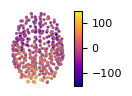

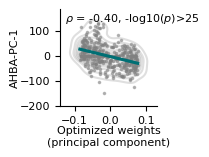

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1916.36it/s]


-0.4 $\mathit{p}$=2e-03
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1904.55it/s]

-0.4 $\mathit{p}$=8e-04


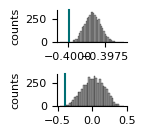

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


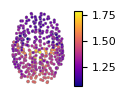

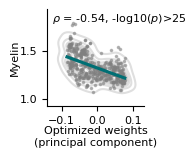

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1937.66it/s]


-0.54 -log10($\mathit{p}$)>25
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1924.22it/s]


-0.54 -log10($\mathit{p}$)>25


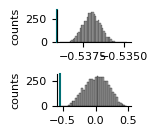

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


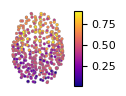

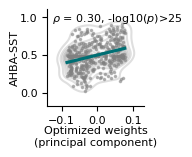

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1839.65it/s]


0.3 $\mathit{p}$=1e-03
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1888.62it/s]


0.3 $\mathit{p}$=9e-03


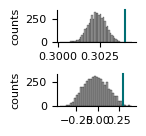

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


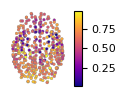

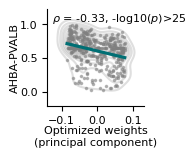

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1895.06it/s]


-0.33 $\mathit{p}$=8e-03
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1895.38it/s]

-0.33 $\mathit{p}$=2e-03


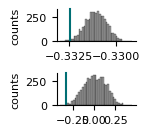

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


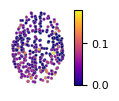

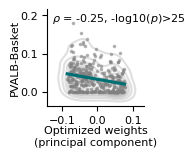

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1916.63it/s]


-0.25 $\mathit{p}$=3e-02
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1920.15it/s]


-0.25 $\mathit{p}$=5e-03


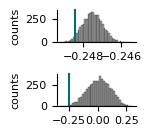

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


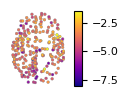

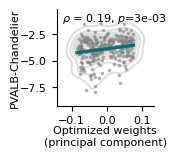

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1989.94it/s]


0.19 -log10($\mathit{p}$)>25
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1981.86it/s]

0.19 $\mathit{p}$=3e-02


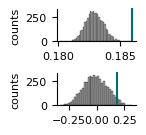

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


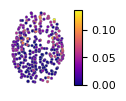

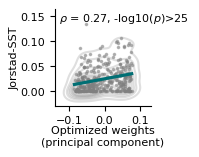

hcp_adj_perm


100%|██████████| 5000/5000 [00:02<00:00, 1953.27it/s]


0.27 -log10($\mathit{p}$)>25
hcp_state_perm


100%|██████████| 5000/5000 [00:02<00:00, 1957.70it/s]


0.27 $\mathit{p}$=7e-03


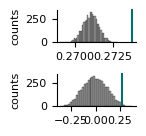

In [30]:
my_colors = get_my_colors(cat_trio=True, as_list=True)

for column in df_neuro.columns:
    brain_map = df_neuro[column].values
    nan_mask = ~np.isnan(brain_map)

    f = brain_scatter_plot(parcel_coords=parc_centroids[nan_mask], node_data=brain_map[nan_mask], fig_height=1, add_colorbar=True)
    plt.show()
    f.savefig(os.path.join(outdir, '{0}_brain_map.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)

    f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
    reg_plot(adjacency_weights_plot[nan_mask], brain_map[nan_mask], xlabel=xlabel, ylabel=column, ax=ax, annotate='spearman')
    plt.show()
    f.savefig(os.path.join(outdir, 'average_optimized_weights_{0}_correlation.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)

    if run_null:
        my_colors = get_my_colors(cat_trio=True, as_list=True)
        f, ax = plt.subplots(n_nulls, 1, figsize=(1.5, 1.4))

        observed_corr = sp.stats.spearmanr(adjacency_weights_plot[nan_mask], brain_map[nan_mask])[0]
        for n, which_null in enumerate(nulls):
            print(which_null)
            null_corr = np.zeros(n_perms)
            for i in tqdm(np.arange(n_perms)):
                null_corr[i] = sp.stats.spearmanr(adjacency_weights_null_pca[n, i, nan_mask], brain_map[nan_mask])[0]
                
            p_val = get_null_p(observed_corr, null_corr, version='smallest')
            print(np.round(observed_corr, 2), get_p_val_string(p_val))
            null_plot(observed_corr, null_corr, '', ax=ax[n], p_val=p_val, add_text=False)

        f.tight_layout()
        plt.show()
        f.savefig(os.path.join(outdir, 'average_optimized_weights_{0}_correlation_nulls.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)